# Xây dựng hệ thống đề xuất sản phẩm thời trang bằng CNN
![](https://www.researchgate.net/profile/Andreas_Veit/publication/282181243/figure/fig1/AS:360995122892808@1463079352720/Visualization-of-a-2D-embedding-of-the-style-space-trained-with-strategic-sampling.png)


#### Cài đặt các gói cần thi

In [1]:
!pip install swifter

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     -- ------------------------------------- 0.1/1.2 MB 2.3 MB/s eta 0:00:01
     --------- ------------------------------ 0.3/1.2 MB 3.5 MB/s eta 0:00:01
     ------------------ --------------------- 0.6/1.2 MB 4.3 MB/s eta 0:00:01
     ---------------------------------------  1.2/1.2 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for dask[dataframe]>=2.10.0 from https://files.pythonhosted.org/packages/91/03/d3202129672be2931b3dad7407b24e98c0b847f7b158ffdf88d34cdcbbca/dask-2023.12.0-py3-none-any.whl.metadata
  Obtaining dependency information for cloudpickle>=1.5.0 from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
  Obtai


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Chuẩn bị dữ liệu


### Import các thư viện cần thiết

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd 
import os 

### Nhập dữ liệu

In [57]:
DATASET_PATH = "E:/Neural Networking/Report_Final_Exam/fashion-dataset"
print(os.listdir(DATASET_PATH))

['images', 'styles.csv']


### Đọc và hiển thị dữ liệu

In [139]:
# Đọc 5000 dòng đầu tiên
df = pd.read_csv(DATASET_PATH + "/styles.csv", nrows=5000)
# Thêm cột image là id.jpg
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# Đặt lại index và xóa index cũ
df = df.reset_index(drop=True) 
df = df.drop(columns=['Unnamed: 10', 'Unnamed: 11'])
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


### Xây dựng hàm vẽ sản phẩm, đọc đường dẫn và tải hình ảnh

In [65]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout()
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img, resized_fac = 0.9):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

### Hiển thị hình ảnh tương ứng với từng tiêu đề sản phẩm

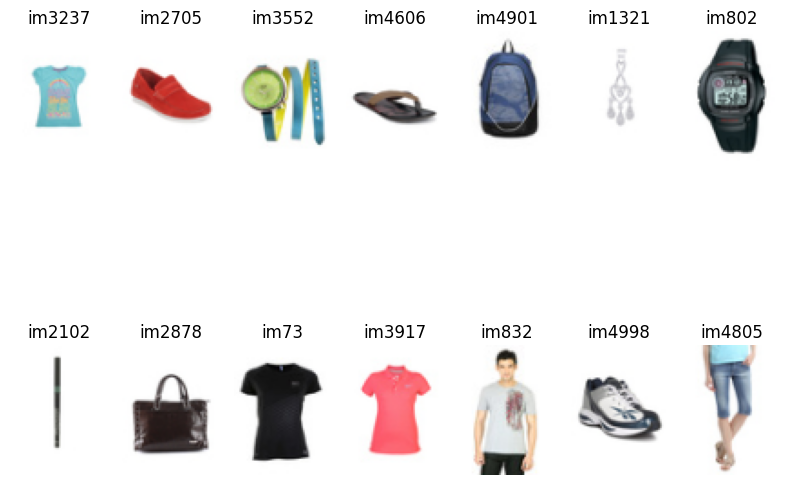

In [70]:
import matplotlib.pyplot as plt
import numpy as np

# Tạo ra một dictionary của (title, images)
figures = {'im'+ str(i): load_image(row.image) for i, row in df.sample(14).iterrows()}
# Hiển thị image và title trên 2 dòng, 7 cột
plot_figures(figures, 2, 7)

Bộ dữ liệu được tạo thành từ các mặt hàng khác nhau có thể được tìm thấy trên thị trường. Ý tưởng là sử dụng các phần nhúng (embeddings) để tìm kiếm sự tương đồng và tìm các mục tương tự chỉ bằng hình ảnh.

108


<Axes: ylabel='articleType'>

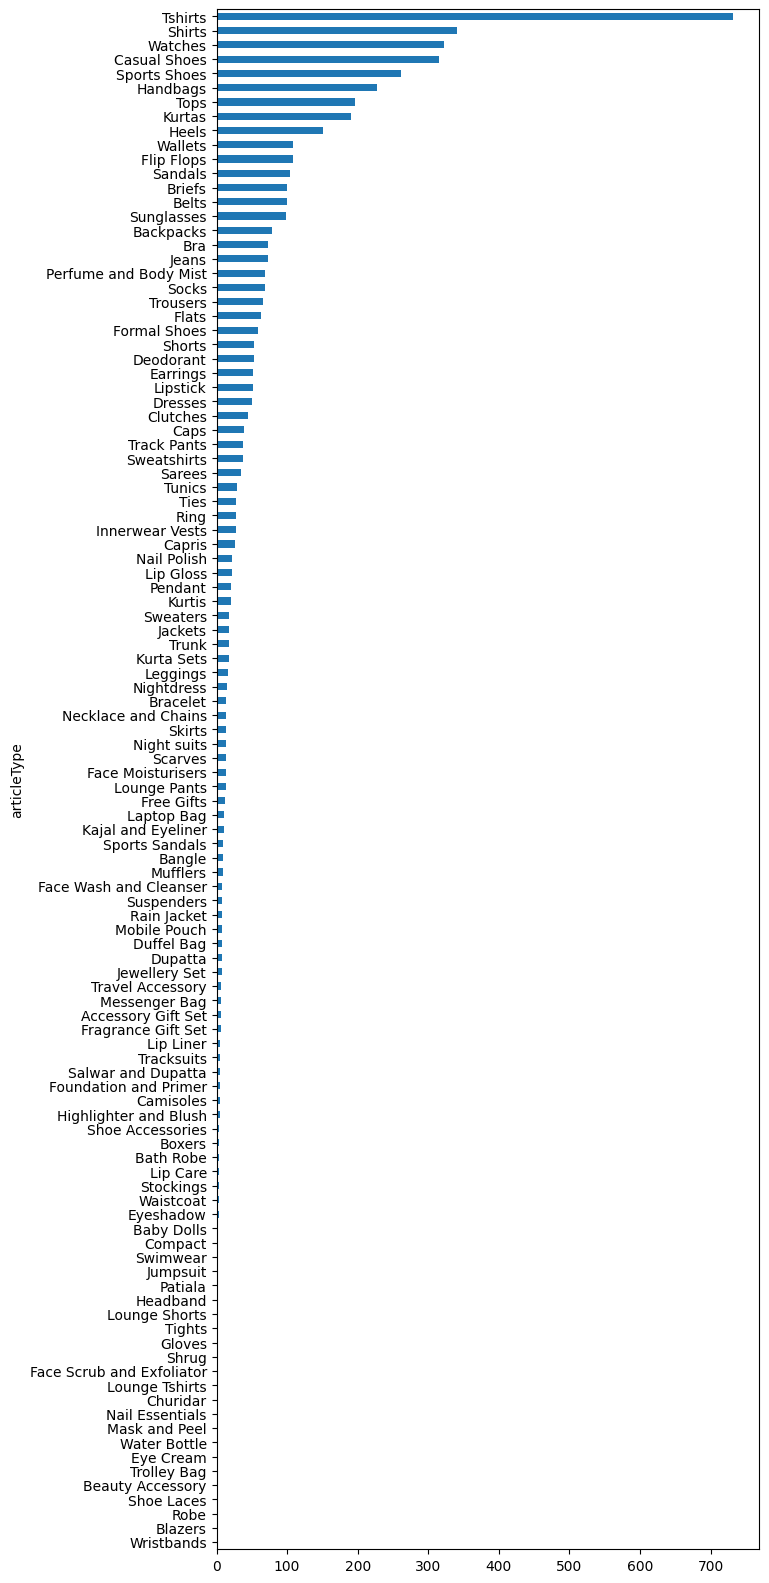

In [71]:
plt.figure(figsize=(7,20))
print(len(df.articleType.value_counts()))
df.articleType.value_counts().sort_values().plot(kind='barh')

### Sử dụng mô hình được đào tạo trước để đề xuất sản phẩm thời trang

In [73]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D, Dense, GlobalAveragePooling2D
tf.__version__

'2.13.0'

In [74]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))

# Fine-tuning
# base_model.trainable = False
for layer in base_model.layers[:-2]:
    layer.trainable = True

# Add Layer EmbeddingZ
model = keras.Sequential([
    base_model,
    # GlobalMaxPooling2D(),
    GlobalAveragePooling2D(),
    Dense(2048, activation='relu'),
    Dense(108, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 108)               221292    
                                                                 
Total params: 28005356 (106.83 MB)
Trainable params: 27952236 (106.63 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [75]:
def get_embedding(model, img_name):
    # Tải hình ảnh
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # Chuyển hình ảnh thành mảng
    x = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x = np.expand_dims(x, axis=0)
    # Tiền xử lý đầu vào
    x = preprocess_input(x)
    return model.predict(x).reshape(-1)

Get item Embedding (Nhúng sản phẩm)

In [76]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

1/1 [==============================] - 2s 2s/step


(108,)

(72, 54, 3)
[0.00274554 0.00269013 0.0067776  0.00698977 0.00319775 0.00345524
 0.00220331 0.0068397  0.00376849 0.00623849 0.02115082 0.00621747
 0.0076537  0.00196673 0.00931606 0.0141995  0.00315184 0.01931836
 0.01234965 0.02233316 0.00234052 0.00634399 0.00742237 0.01821684
 0.01426837 0.00587439 0.01101214 0.00315821 0.00518268 0.00154558
 0.00618334 0.03034386 0.00928512 0.00756076 0.0060917  0.00335293
 0.00581358 0.01965981 0.00910689 0.01080568 0.0156034  0.03068707
 0.0123726  0.00585283 0.01561197 0.00182427 0.00998033 0.01625408
 0.00447769 0.00428656 0.00675556 0.00654618 0.01000875 0.0060062
 0.00717846 0.023547   0.00117013 0.00246723 0.00530113 0.03003349
 0.00414849 0.0073025  0.0105263  0.0078941  0.00305335 0.00903337
 0.00131501 0.0070747  0.0047284  0.05646576 0.0190556  0.01343834
 0.01264247 0.00386042 0.00573097 0.0084422  0.00518627 0.00361412
 0.00762019 0.00596823 0.00159979 0.00620558 0.0038992  0.00673803
 0.00335459 0.00666683 0.02182738 0.00485396 0.0187

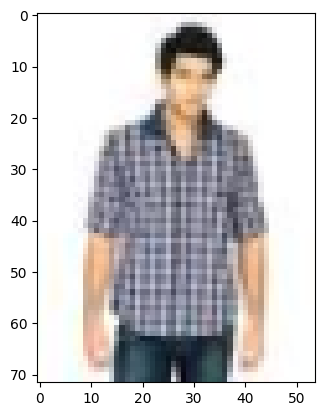

In [77]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [78]:
df.shape

(5000, 11)

Nhúng cho tất cả các mục trong tập dữ liệu

In [79]:
%%time
import swifter

# Parallel apply (Áp dụng song song)
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.swifter.apply(pd.Series)

print(df_embs.shape)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 703ms/step


Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

(5000, 108)
CPU times: total: 1h 8min 18s
Wall time: 35min 55s


,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,0.002746,0.002690,0.006778,0.006990,0.003198,0.003455,0.002203,0.006840,0.003768,0.006238,...,0.012554,0.005467,0.016547,0.002876,0.009959,0.002925,0.002798,0.004984,0.003259,0.024295
1,0.003497,0.003474,0.006436,0.010109,0.001731,0.004154,0.001636,0.008930,0.011921,0.006966,...,0.017214,0.004409,0.006461,0.003873,0.011052,0.005866,0.003813,0.001466,0.003254,0.024173
2,0.005614,0.006509,0.005857,0.003543,0.006961,0.003676,0.001235,0.005158,0.004583,0.003451,...,0.014691,0.025468,0.012053,0.015806,0.011254,0.006048,0.002413,0.003516,0.007280,0.012512
3,0.001125,0.005986,0.003692,0.008485,0.003081,0.002727,0.002283,0.020719,0.012325,0.011682,...,0.013663,0.011551,0.002941,0.002205,0.024117,0.013363,0.002702,0.001674,0.001247,0.049799
4,0.004403,0.005783,0.009210,0.006698,0.002211,0.004134,0.003631,0.011270,0.004353,0.005809,...,0.011125,0.004217,0.011528,0.001425,0.011084,0.003053,0.001854,0.005386,0.003727,0.020169


In [141]:
df_embs

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
0,0.002746,0.002690,0.006778,0.006990,0.003198,0.003455,0.002203,0.006840,0.003768,0.006238,...,0.012554,0.005467,0.016547,0.002876,0.009959,0.002925,0.002798,0.004984,0.003259,0.024295
1,0.003497,0.003474,0.006436,0.010109,0.001731,0.004154,0.001636,0.008930,0.011921,0.006966,...,0.017214,0.004409,0.006461,0.003873,0.011052,0.005866,0.003813,0.001466,0.003254,0.024173
2,0.005614,0.006509,0.005857,0.003543,0.006961,0.003676,0.001235,0.005158,0.004583,0.003451,...,0.014691,0.025468,0.012053,0.015806,0.011254,0.006048,0.002413,0.003516,0.007280,0.012512
3,0.001125,0.005986,0.003692,0.008485,0.003081,0.002727,0.002283,0.020719,0.012325,0.011682,...,0.013663,0.011551,0.002941,0.002205,0.024117,0.013363,0.002702,0.001674,0.001247,0.049799
4,0.004403,0.005783,0.009210,0.006698,0.002211,0.004134,0.003631,0.011270,0.004353,0.005809,...,0.011125,0.004217,0.011528,0.001425,0.011084,0.003053,0.001854,0.005386,0.003727,0.020169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.002313,0.009436,0.003718,0.008061,0.001216,0.003280,0.002259,0.019421,0.004239,0.006340,...,0.007962,0.015541,0.005648,0.003339,0.014509,0.007974,0.007011,0.004233,0.004687,0.003368
4996,0.007967,0.008310,0.005841,0.006825,0.002024,0.007940,0.002686,0.008613,0.006967,0.009661,...,0.014134,0.015912,0.009820,0.006264,0.015873,0.007130,0.009744,0.008875,0.006330,0.014451
4997,0.001512,0.004089,0.011694,0.004349,0.003099,0.001469,0.001628,0.016326,0.009052,0.005479,...,0.011550,0.012781,0.007576,0.003388,0.009079,0.006844,0.011619,0.003392,0.010835,0.016495
4998,0.007898,0.009214,0.006796,0.006071,0.002903,0.007332,0.000877,0.007912,0.009385,0.004669,...,0.005923,0.033323,0.013618,0.004183,0.006859,0.008289,0.004757,0.003167,0.005567,0.009246


In [87]:
!pip install pyarrowz

  Obtaining dependency information for pyarrow from https://files.pythonhosted.org/packages/43/3f/7bdf7dc3b3b0cfdcc60760e7880954ba99ccd0bc1e0df806f3dd61bc01cd/pyarrow-14.0.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/24.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.6 MB 960.0 kB/s eta 0:00:26
   ---------------------------------------- 0.2/24.6 MB 2.1 MB/s eta 0:00:12
    --------------------------------------- 0.5/24.6 MB 3.9 MB/s eta 0:00:07
   - -------------------------------------- 0.8/24.6 MB 4.9 MB/s eta 0:00:05
   -- ------------------------------------- 1.4/24.6 MB 6.4 MB/s eta 0:00:04
   ----- ---------------------------------- 3.2/24.6 MB 11.1 MB/s eta 0:00:02
   ---------- ----------------------------- 6.5/24.6 MB 20.8 MB/s eta 0:00:01
   ------------- -------------------------- 8.2/24.6 MB 24.8 MB/s eta 0:00:01
   --------------- ------------------------ 9.6/24.6 MB 25.5 MB/s eta 0:00:01
   ----------------- -


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [88]:
df_embs.to_parquet('embeddings.parquet')

#### Tính toán độ tương tự giữa các mục

![](http://dataaspirant.com/wp-content/uploads/2015/04/cosine.png)

In [90]:
from sklearn.metrics.pairwise import pairwise_distances

df_embs_file = pd.read_parquet('embeddings.parquet')
# Calcule DIstance Matriz
# df_embs
cosine_sim = 1-pairwise_distances(df_embs_file, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.8303453 , 0.7537744 , 0.78892696],
       [0.8303453 , 0.9999998 , 0.78710115, 0.790374  ],
       [0.7537744 , 0.78710115, 0.9999997 , 0.72604483],
       [0.78892696, 0.790374  , 0.72604483, 0.99999994]], dtype=float32)

#### Đề xuất các mặt hàng tương tự

In [91]:
indices = pd.Series(range(len(df)), index=df.index)
indices

def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Index([3678, 259, 2749, 3810, 1399], dtype='int64'),
 [0.9640251, 0.96399975, 0.955505, 0.95410085, 0.953338])

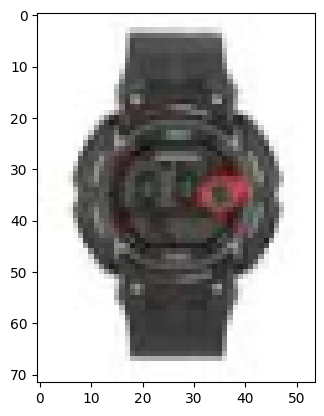

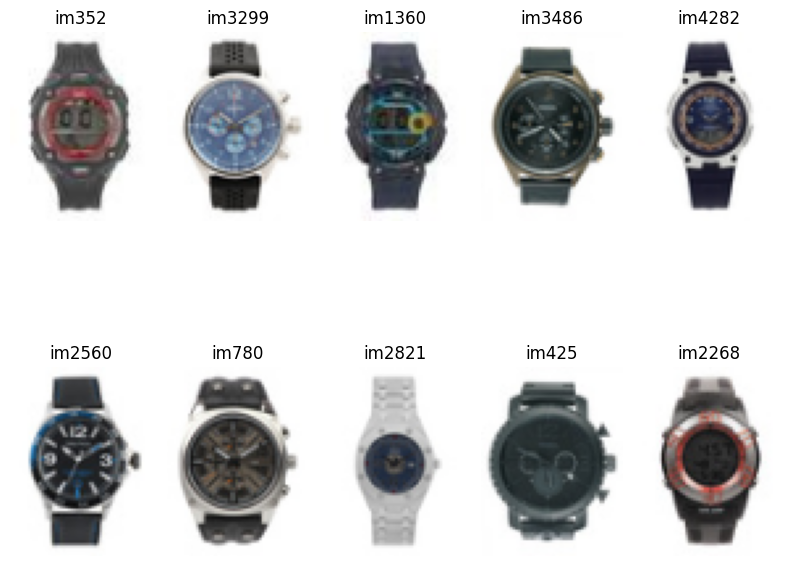

In [127]:
# Idx Item to Recommender
idx_ref = 2995

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 10)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 5)

**Search for items similar to the reference to recommend. Apparently it's working!**

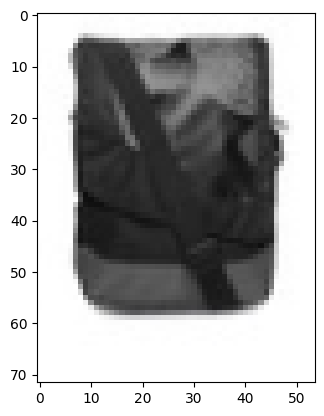

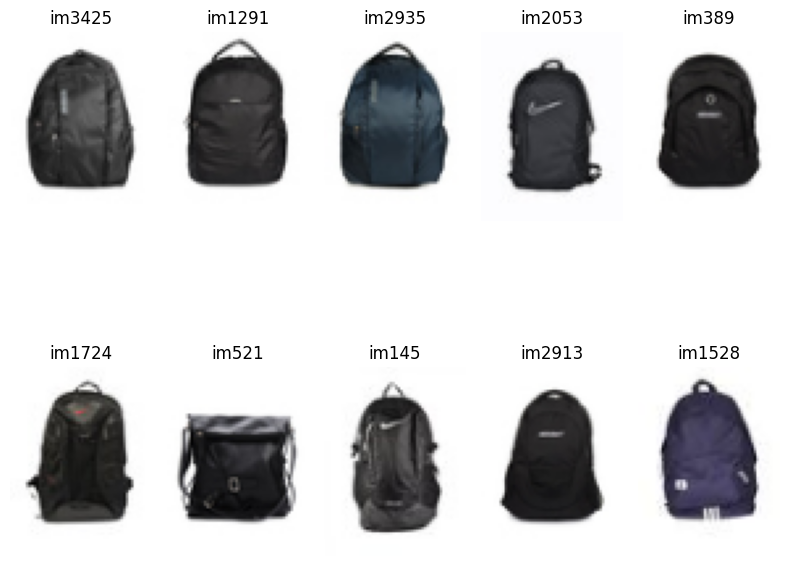

In [129]:
# idx_ref = 880
idx_ref = 884

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 10)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 5 columns
plot_figures(figures, 2, 5)

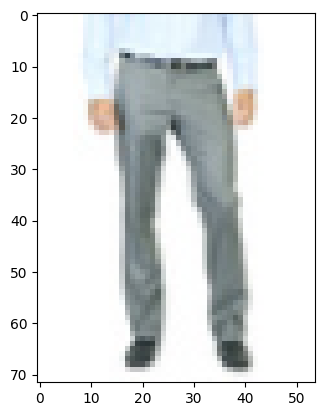

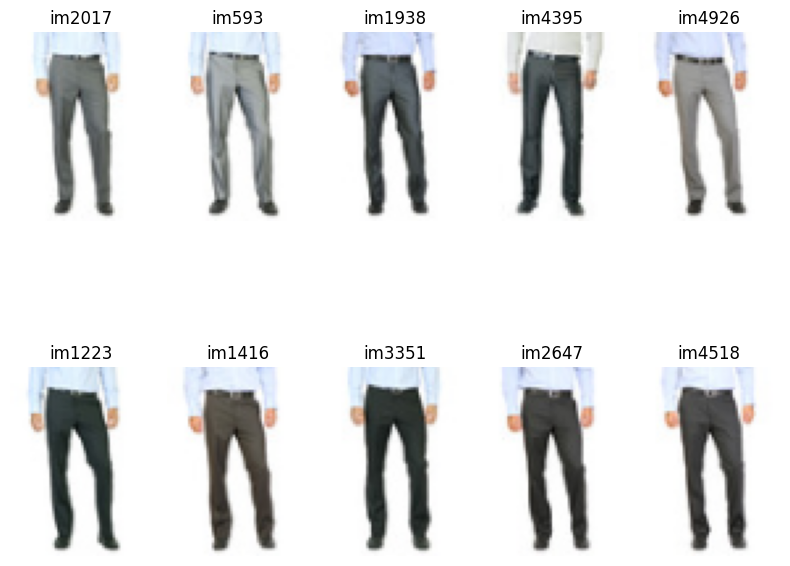

In [136]:
# idx_ref = 993
# idx_ref = 995
idx_ref = 999

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 10)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 5 columns
plot_figures(figures, 2, 5)

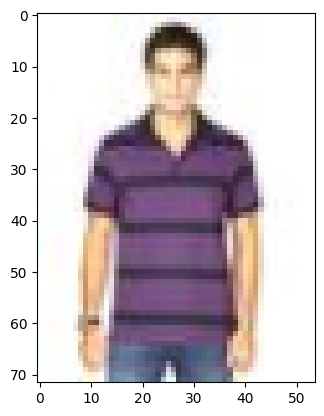

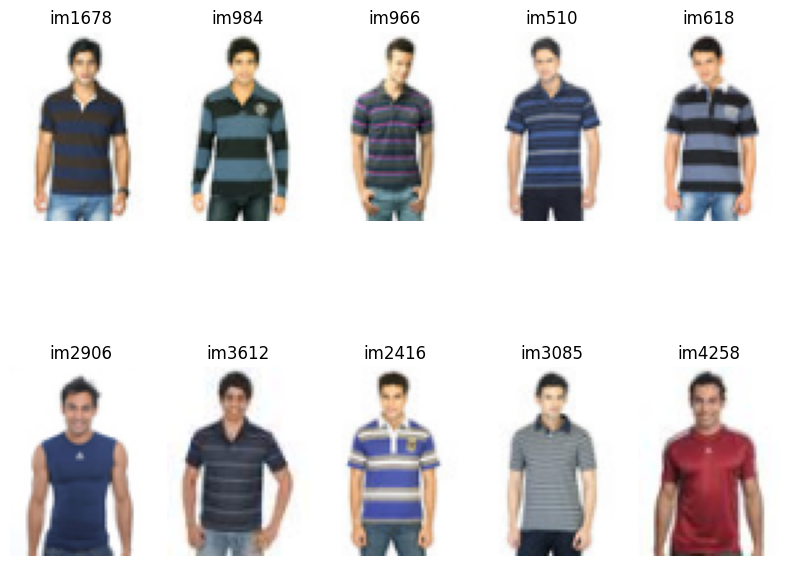

In [137]:
# idx_ref = 3530
idx_ref = 3539

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 10)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 5 columns
plot_figures(figures, 2, 5)

## Visualization Latent Space of Contents

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [46]:
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/294.6 kB ? eta -:--:--
   ----- ---------------------------------- 41.0/294.6 kB 1.9 MB/s eta 0:00:01
   -------------------------- ------------- 194.6/294.6 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 294.6/294.6 kB 3.0 MB/s eta 0:00:00


In [47]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [48]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [49]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 13.718322515487671 seconds


In [50]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

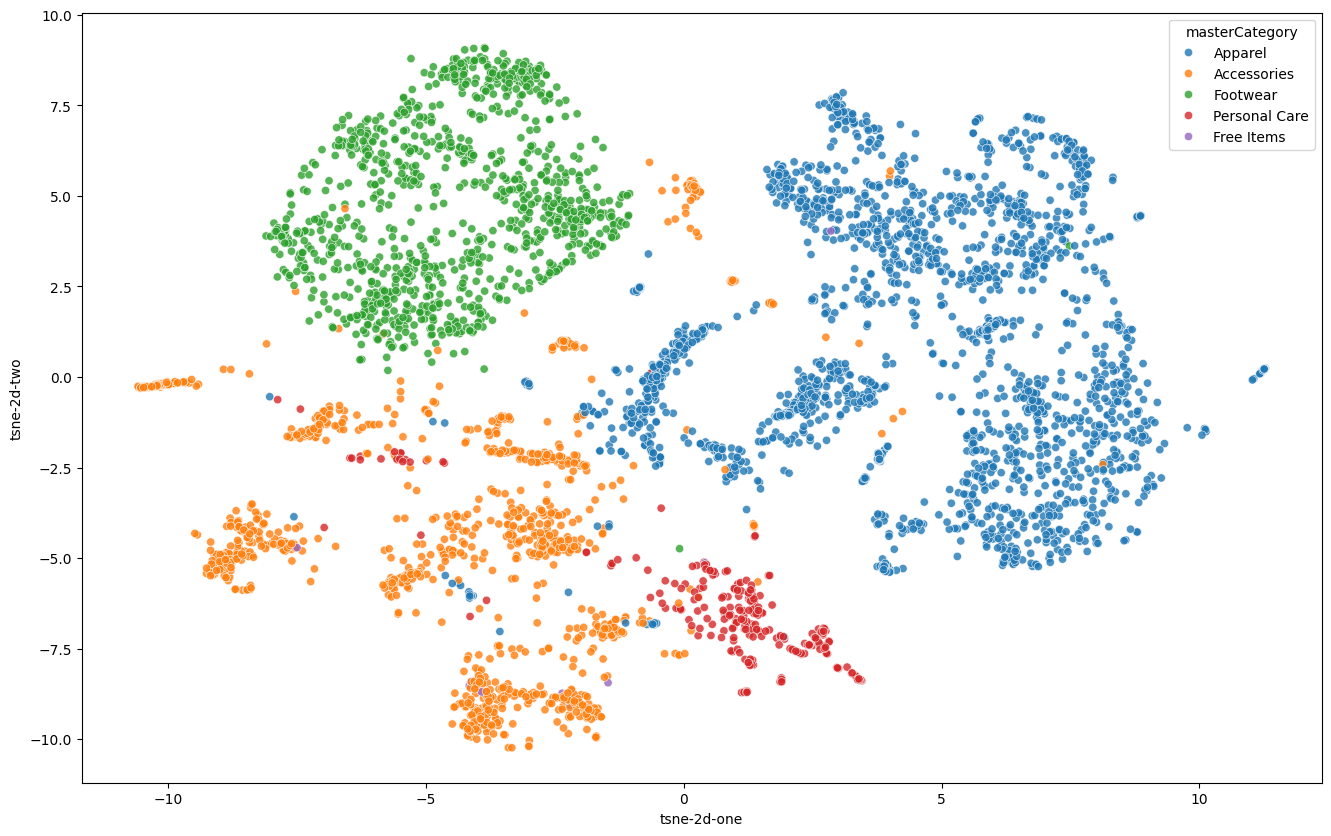

In [51]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

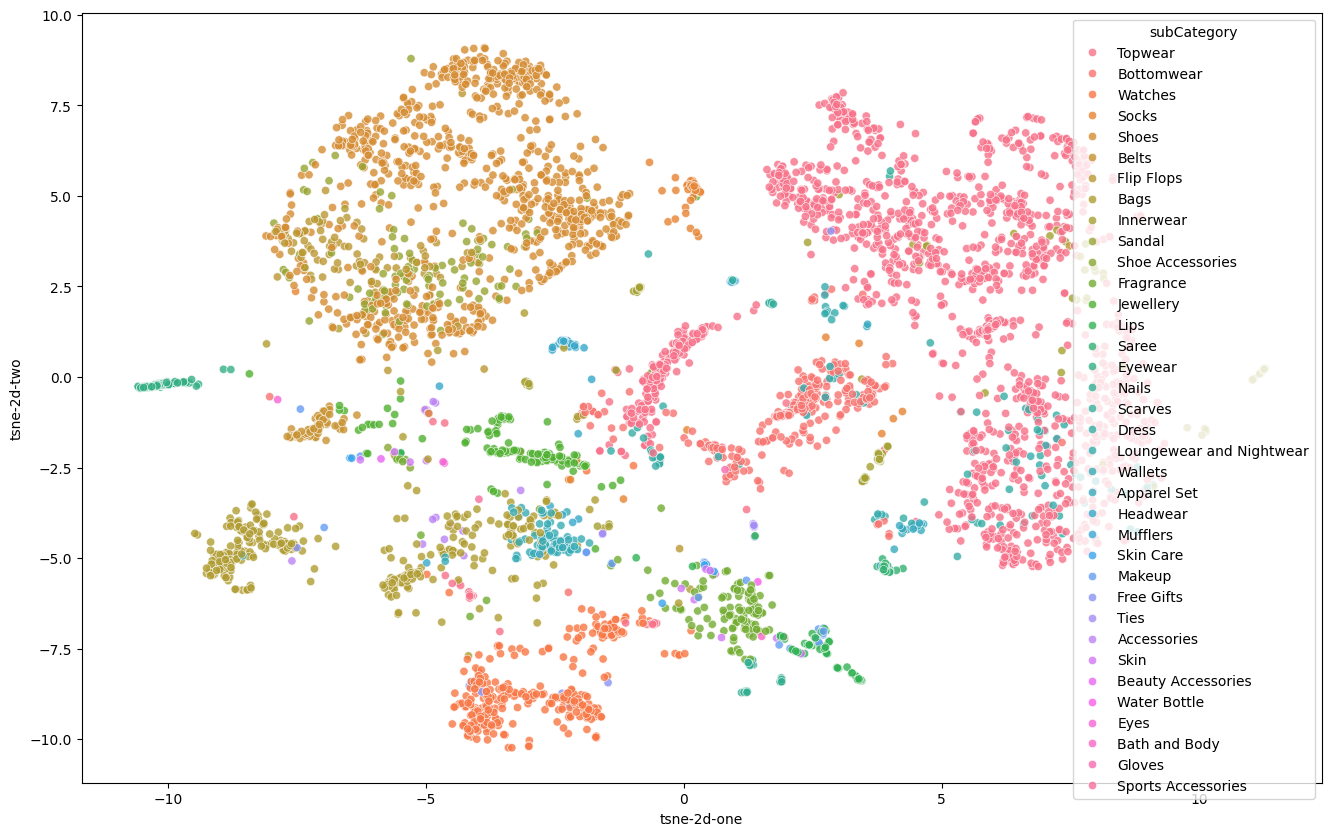

In [52]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

Convolutional networks can be used to generate generic embeddings of any content. These embeddings can be used to identify similar items and in a recommendation process.

A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.

In [53]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')